#### Install the Python library 'networkx'

In [1]:
 #pip install networkx

In [2]:
# Import libraries
import re  # For regular expressions
import nltk  # For text functions
import matplotlib.pyplot as plt  # For plotting
import pandas as pd  # For dataframes
import networkx as nx  # For network graphs

# Import specific text functions from NLTK
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg

# Download data for NLTK
nltk.download('stopwords', quiet=True)
nltk.download('opinion_lexicon', quiet=True)
nltk.download('punkt', quiet=True)

True

#### Prepare data

In [3]:
austen = gutenberg.sents('austen-emma.txt') # can choose another author name from the available choices
rows_list = []
for row in austen:
    if row:
        innerStr = ' '.join([str(elem) for elem in row]) #convert the list to single string
        rows_list.append([str(innerStr)])

df = pd.DataFrame(rows_list, columns= ['text']).dropna()
df.head()

,text
0,[ Emma by Jane Austen 1816 ]
1,VOLUME I
2,CHAPTER I
3,"Emma Woodhouse , handsome , clever , and rich ..."
4,She was the youngest of the two daughters of a...


#### Tokenize the Data

In [4]:
def clean_text(text):
    text = text.lower() # lowecase
    text = text.replace("'", '')
    text = re.sub(r'[^\w]', ' ', text) # leave only word characters
    text = re.sub(r'\s+', ' ', text) # ommit extra space characters
    text = text.strip()
    return text


df['text'] = df['text'].map(clean_text) 
df['text'] = df['text'].map(word_tokenize) # Split text into words

df.head()

,text
0,"[emma, by, jane, austen, 1816]"
1,"[volume, i]"
2,"[chapter, i]"
3,"[emma, woodhouse, handsome, clever, and, rich,..."
4,"[she, was, the, youngest, of, the, two, daught..."


#### Create word pairs

In [5]:
df['wordpairs'] = df['text'].map(lambda x: list(ngrams(x, 2)))
df = df.explode('wordpairs')

df.head(10)

,text,wordpairs
0,"[emma, by, jane, austen, 1816]","(emma, by)"
0,"[emma, by, jane, austen, 1816]","(by, jane)"
0,"[emma, by, jane, austen, 1816]","(jane, austen)"
0,"[emma, by, jane, austen, 1816]","(austen, 1816)"
1,"[volume, i]","(volume, i)"
2,"[chapter, i]","(chapter, i)"
3,"[emma, woodhouse, handsome, clever, and, rich,...","(emma, woodhouse)"
3,"[emma, woodhouse, handsome, clever, and, rich,...","(woodhouse, handsome)"
3,"[emma, woodhouse, handsome, clever, and, rich,...","(handsome, clever)"
3,"[emma, woodhouse, handsome, clever, and, rich,...","(clever, and)"


#### Sort by frequency

In [6]:
df['wordpairs'].value_counts().head(10)

(to, be)       607
(of, the)      562
(it, was)      448
(in, the)      445
(i, am)        395
(she, had)     332
(she, was)     328
(had, been)    308
(it, is)       299
(i, have)      281
Name: wordpairs, dtype: int64

#### Split word pairs for removing stop words

In [7]:
df = pd.DataFrame(df.wordpairs.values.tolist(), columns=['word1', 'word2']).dropna()

df.head(10)

,word1,word2
0,emma,by
1,by,jane
2,jane,austen
3,austen,1816
4,volume,i
5,chapter,i
6,emma,woodhouse
7,woodhouse,handsome
8,handsome,clever
9,clever,and


In [8]:
df.shape

(154412, 2)

#### Remove stop words

In [9]:
en_stopwords = set(stopwords.words('english'))

df = df[~(df.word1.isin(en_stopwords) | df.word2.isin(en_stopwords))]

df.head()

,word1,word2
2,jane,austen
3,austen,1816
6,emma,woodhouse
7,woodhouse,handsome
8,handsome,clever


In [10]:
df.shape

(24097, 2)

#### Sort word pairs by frequency

In [11]:
df = df.groupby(['word1', 'word2'])\
    .size()\
    .to_frame('n')\
    .reset_index()\
    .sort_values('n', ascending=False)

df.head(20)

,word1,word2,n
9266,mr,knightley,277
9310,mrs,weston,249
9258,mr,elton,214
9105,miss,woodhouse,173
9274,mr,weston,162
5288,frank,churchill,151
9289,mrs,elton,142
9278,mr,woodhouse,132
4334,every,thing,126
9087,miss,fairfax,125


#### Visualize data

In [12]:
df[df.n > 12].head(10)

,word1,word2,n
9266,mr,knightley,277
9310,mrs,weston,249
9258,mr,elton,214
9105,miss,woodhouse,173
9274,mr,weston,162
5288,frank,churchill,151
9289,mrs,elton,142
9278,mr,woodhouse,132
4334,every,thing,126
9087,miss,fairfax,125


#### Visualize network graph

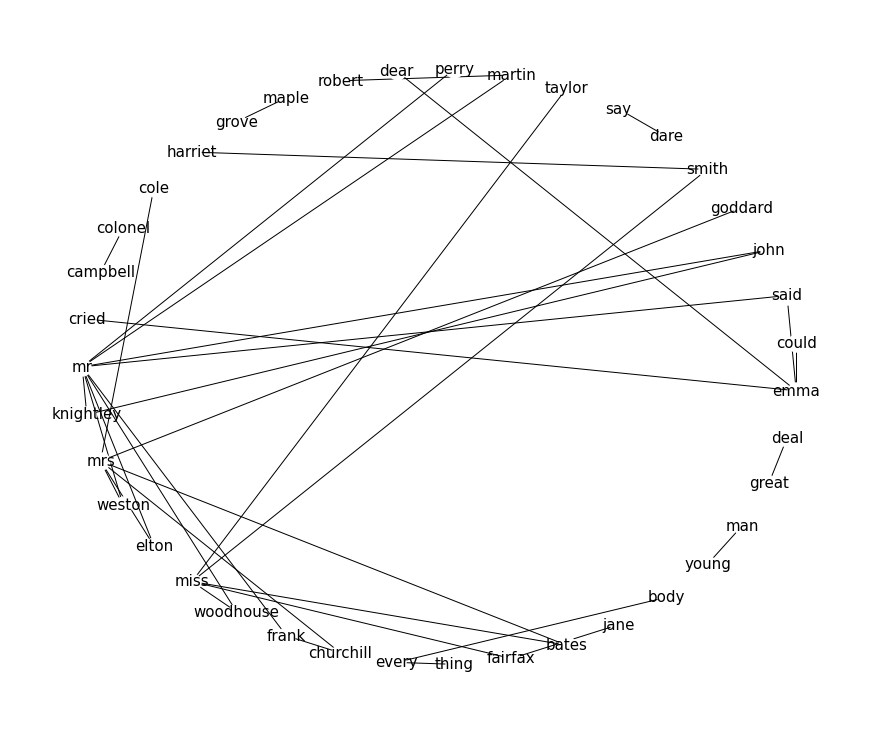

In [13]:
G = nx.from_pandas_edgelist(df[df.n > 25], 'word1', 'word2') #restrict to word pairs that appear more than 25 times.
plt.figure(figsize=(12, 10))
nx.draw_shell(G, with_labels=True, node_color='white', font_size=15)